<a href="https://colab.research.google.com/github/Fatemeh-Rahmani/Adaptive-Channel-SVD-Estimation-for-MIMO-OFDM-Systems/blob/main/Adaptive_Channel_SVD_Estimation_for_MIMO_OFDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Channel SVD Estimation for MIMO-OFDM Systems

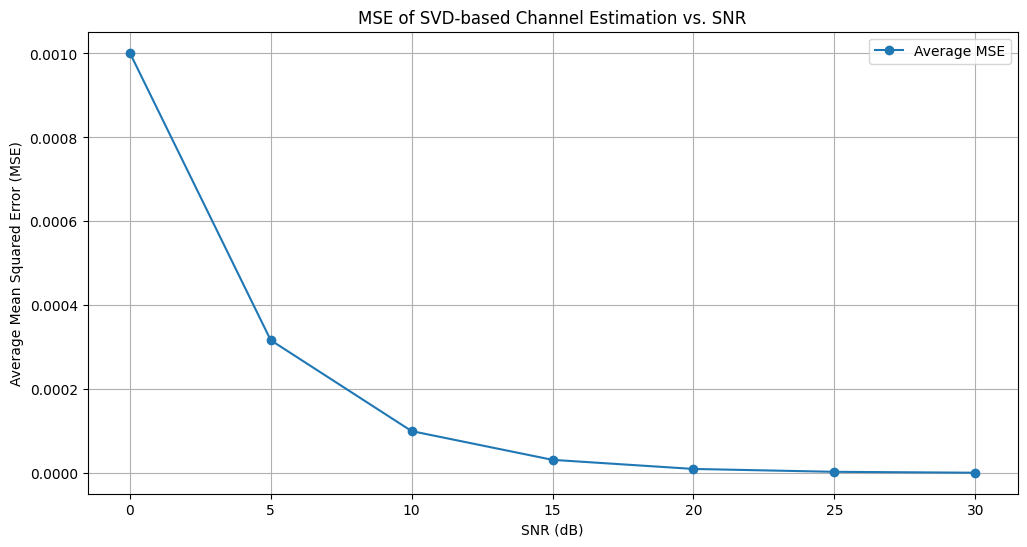

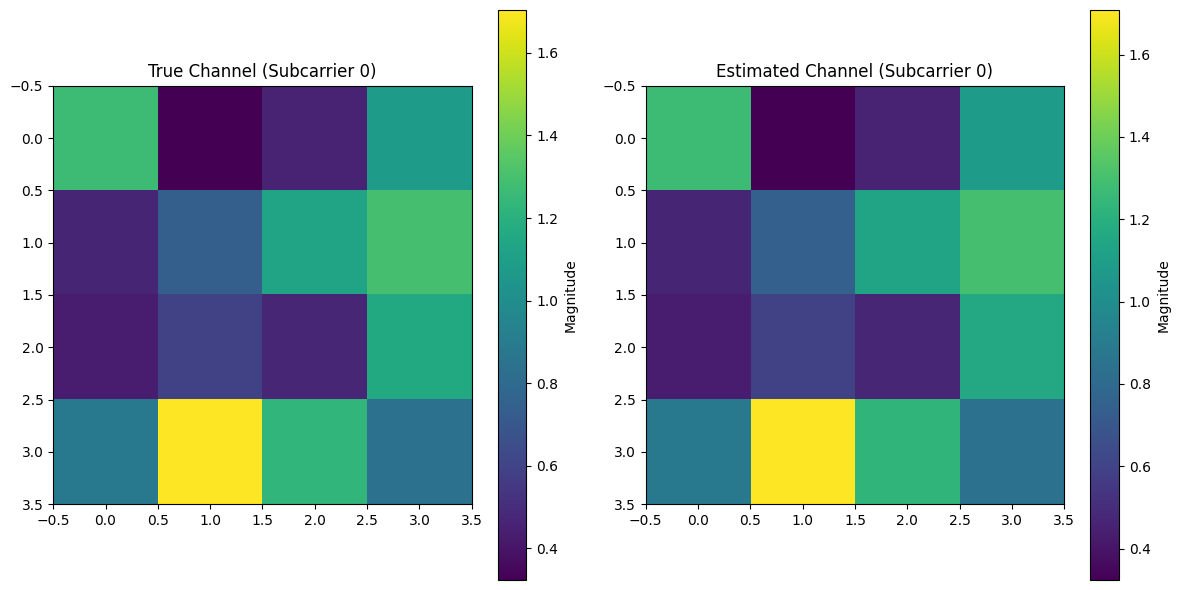

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def generate_mimo_ofdm_data(num_transmit, num_receive, num_subcarriers, num_symbols, snr_db):
    """
    Generates simulated MIMO-OFDM data with specified system parameters and SNR.

    Parameters:
    - num_transmit (int): Number of transmit antennas.
    - num_receive (int): Number of receive antennas.
    - num_subcarriers (int): Number of OFDM subcarriers.
    - num_symbols (int): Number of OFDM symbols.
    - snr_db (float): Signal-to-Noise Ratio (SNR) in dB.

    Returns:
    - channels (ndarray): True MIMO channel matrices for all subcarriers (shape: num_subcarriers x num_receive x num_transmit).
    - symbols (ndarray): Transmitted symbols (shape: num_symbols x num_transmit).
    - received (ndarray): Received signals with noise (shape: num_symbols x num_subcarriers x num_receive).
    """
    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate random MIMO channel matrices (Rayleigh fading)
    channels = (np.random.randn(num_subcarriers, num_receive, num_transmit) +
                1j * np.random.randn(num_subcarriers, num_receive, num_transmit)) / np.sqrt(2)

    # Generate random transmitted symbols (complex Gaussian)
    symbols = (np.random.randn(num_symbols, num_transmit) +
               1j * np.random.randn(num_symbols, num_transmit)) / np.sqrt(2)

    # Calculate average signal power
    signal_power = np.mean(np.abs(symbols) ** 2)

    # Compute noise variance from the specified SNR
    noise_variance = signal_power / (10 ** (snr_db / 10))

    # Initialize received signal array
    received = np.zeros((num_symbols, num_subcarriers, num_receive), dtype=complex)

    # Generate received signals for each subcarrier
    for k in range(num_subcarriers):
        # Apply MIMO channel to transmitted symbols
        received[:, k, :] = symbols @ channels[k].T

    # Add complex Gaussian noise to the received signals
    noise = (np.sqrt(noise_variance / 2) *
             (np.random.randn(*received.shape) + 1j * np.random.randn(*received.shape)))
    received += noise

    return channels, symbols, received

def svd_channel_estimation(channels, received, symbols):
    """Perform SVD-based channel estimation for MIMO-OFDM systems."""
    num_subcarriers, num_receive, num_transmit = channels.shape
    estimated_channels = np.zeros_like(channels, dtype=complex)
    mse = []

    for k in range(num_subcarriers):
        # Perform pseudo-inverse estimation using received and symbols
        symbols_pseudo_inverse = np.linalg.pinv(symbols)
        estimated_channels[k] = received[:, k, :].T @ symbols_pseudo_inverse.T

        # Calculate MSE for this subcarrier
        mse.append(np.mean(np.abs(channels[k] - estimated_channels[k]) ** 2))

    return estimated_channels, mse

def simulate_for_snrs(snr_values, num_transmit, num_receive, num_subcarriers, num_symbols):
    """Simulate the MIMO-OFDM system for a range of SNR values."""
    avg_mse_per_snr = []

    for snr_db in snr_values:
        # Generate MIMO-OFDM Data
        channels, symbols, received = generate_mimo_ofdm_data(num_transmit, num_receive, num_subcarriers, num_symbols, snr_db)

        # Perform SVD-based Channel Estimation
        _, mse = svd_channel_estimation(channels, received, symbols)

        # Average MSE across subcarriers
        avg_mse_per_snr.append(np.mean(mse))

    return avg_mse_per_snr

# Simulation Parameters
num_transmit = 4
num_receive = 4
num_subcarriers = 64
num_symbols = 1000
snr_values = [0, 5, 10, 15, 20, 25, 30]  # SNR values in dB

# Simulate for different SNR values
avg_mse_per_snr = simulate_for_snrs(snr_values, num_transmit, num_receive, num_subcarriers, num_symbols)

# Plot Average MSE vs. SNR
plt.figure(figsize=(12, 6))
plt.plot(snr_values, avg_mse_per_snr, marker='o', label="Average MSE")
plt.title("MSE of SVD-based Channel Estimation vs. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Average Mean Squared Error (MSE)")
plt.grid()
plt.legend()
plt.show()

# Compare true and estimated channel for a single SNR and subcarrier
snr_db = 20  # Example SNR for detailed comparison
channels, symbols, received = generate_mimo_ofdm_data(num_transmit, num_receive, num_subcarriers, num_symbols, snr_db)
estimated_channels, _ = svd_channel_estimation(channels, received, symbols)

subcarrier_idx = 0  # Example subcarrier
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("True Channel (Subcarrier {})".format(subcarrier_idx))
plt.imshow(np.abs(channels[subcarrier_idx]), cmap="viridis")
plt.colorbar(label="Magnitude")
plt.subplot(1, 2, 2)
plt.title("Estimated Channel (Subcarrier {})".format(subcarrier_idx))
plt.imshow(np.abs(estimated_channels[subcarrier_idx]), cmap="viridis")
plt.colorbar(label="Magnitude")
plt.tight_layout()
plt.show()


## complicated channel model, incorporating frequency selectivity, path loss,and shadowing effects

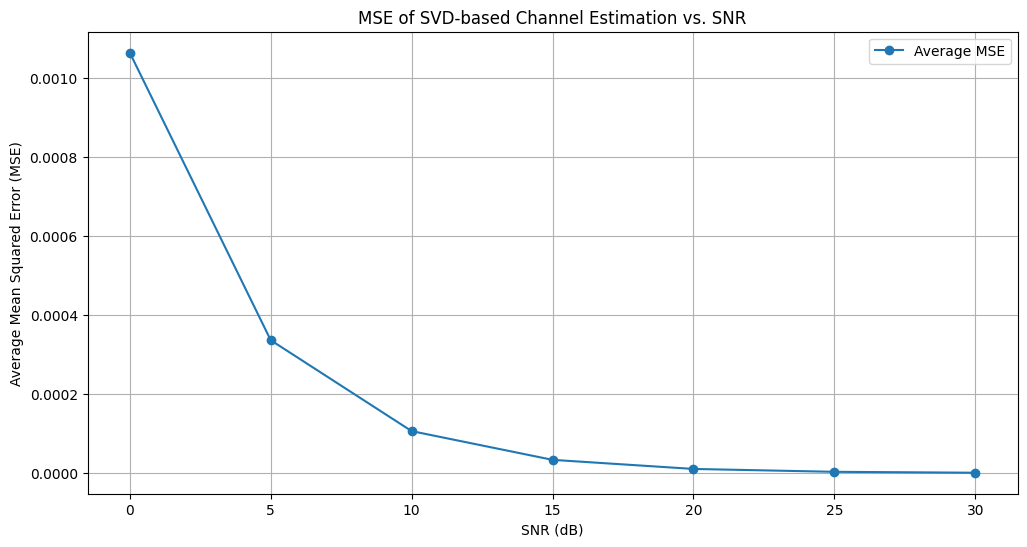

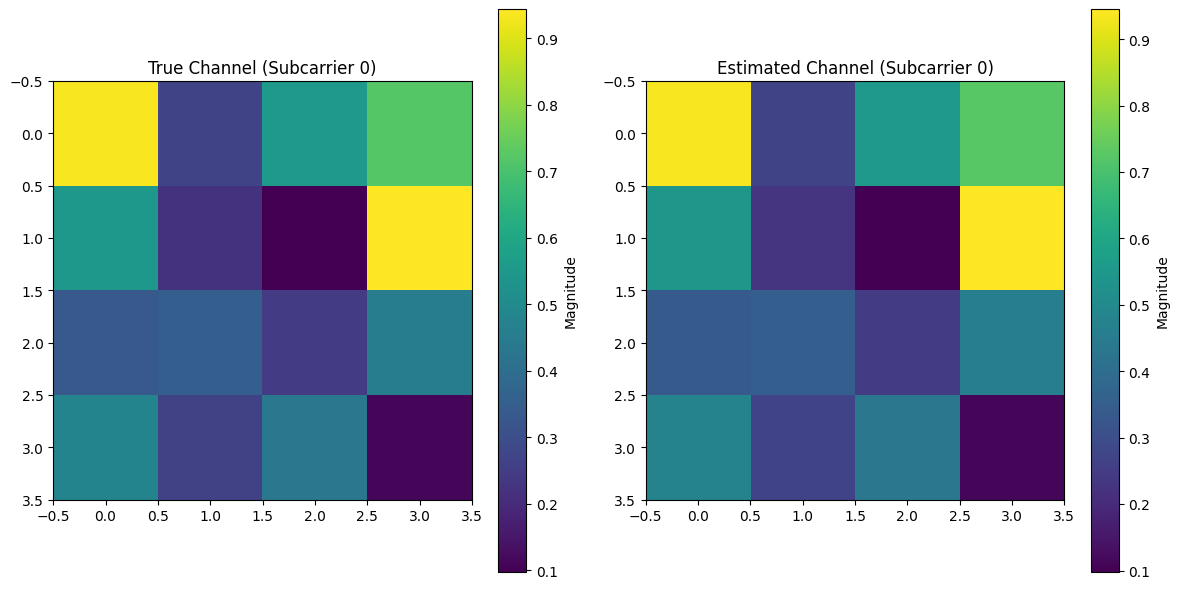

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_mimo_ofdm_data(num_transmit, num_receive, num_subcarriers, num_symbols, snr_db):

    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate random MIMO channel matrices (Rayleigh fading with frequency selectivity)
    num_taps = 5  # Number of taps for frequency selectivity
    delay_spread = np.linspace(0, 1, num_taps).reshape(1, 1, 1, num_taps)
    path_gains = (np.random.randn(num_subcarriers, num_receive, num_transmit, num_taps) +
                  1j * np.random.randn(num_subcarriers, num_receive, num_transmit, num_taps)) / np.sqrt(2 * num_taps)

    # Apply delay spread to model frequency selectivity
    exp_term = np.exp(-2j * np.pi * delay_spread * np.arange(num_subcarriers).reshape(-1, 1, 1, 1))
    channels = np.sum(path_gains * exp_term, axis=-1)

    # Introduce path loss and shadowing
    path_loss = 10 ** (-3 / 10)  # Fixed path loss factor
    shadowing = 10 ** (np.random.normal(0, 2, (num_subcarriers, num_receive, num_transmit)) / 10)  # Log-normal shadowing
    channels *= path_loss * shadowing

    # Generate random transmitted symbols (complex Gaussian)
    symbols = (np.random.randn(num_symbols, num_transmit) +
               1j * np.random.randn(num_symbols, num_transmit)) / np.sqrt(2)

    # Calculate average signal power
    signal_power = np.mean(np.abs(symbols) ** 2)

    # Compute noise variance from the specified SNR
    noise_variance = signal_power / (10 ** (snr_db / 10))

    # Initialize received signal array
    received = np.zeros((num_symbols, num_subcarriers, num_receive), dtype=complex)

    # Generate received signals for each subcarrier
    for k in range(num_subcarriers):
        # Apply MIMO channel to transmitted symbols
        received[:, k, :] = symbols @ channels[k].T

    # Add complex Gaussian noise to the received signals
    noise = (np.sqrt(noise_variance / 2) *
             (np.random.randn(*received.shape) + 1j * np.random.randn(*received.shape)))
    received += noise

    return channels, symbols, received

def svd_channel_estimation(channels, received, symbols):
    """Perform SVD-based channel estimation for MIMO-OFDM systems."""
    num_subcarriers, num_receive, num_transmit = channels.shape
    estimated_channels = np.zeros_like(channels, dtype=complex)
    mse = []

    for k in range(num_subcarriers):
        # Perform pseudo-inverse estimation using received and symbols
        symbols_pseudo_inverse = np.linalg.pinv(symbols)
        estimated_channels[k] = received[:, k, :].T @ symbols_pseudo_inverse.T

        # Calculate MSE for this subcarrier
        mse.append(np.mean(np.abs(channels[k] - estimated_channels[k]) ** 2))

    return estimated_channels, mse

def simulate_for_snrs(snr_values, num_transmit, num_receive, num_subcarriers, num_symbols):
    """Simulate the MIMO-OFDM system for a range of SNR values."""
    avg_mse_per_snr = []

    for snr_db in snr_values:
        # Generate MIMO-OFDM Data
        channels, symbols, received = generate_mimo_ofdm_data(num_transmit, num_receive, num_subcarriers, num_symbols, snr_db)

        # Perform SVD-based Channel Estimation
        _, mse = svd_channel_estimation(channels, received, symbols)

        # Average MSE across subcarriers
        avg_mse_per_snr.append(np.mean(mse))

    return avg_mse_per_snr

# Simulation Parameters
num_transmit = 4
num_receive = 4
num_subcarriers = 64
num_symbols = 1000
snr_values = [0, 5, 10, 15, 20, 25, 30]  # SNR values in dB

# Simulate for different SNR values
avg_mse_per_snr = simulate_for_snrs(snr_values, num_transmit, num_receive, num_subcarriers, num_symbols)

# Plot Average MSE vs. SNR
plt.figure(figsize=(12, 6))
plt.plot(snr_values, avg_mse_per_snr, marker='o', label="Average MSE")
plt.title("MSE of SVD-based Channel Estimation vs. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Average Mean Squared Error (MSE)")
plt.grid()
plt.legend()
plt.show()

# Compare true and estimated channel for a single SNR and subcarrier
snr_db = 20  # Example SNR for detailed comparison
channels, symbols, received = generate_mimo_ofdm_data(num_transmit, num_receive, num_subcarriers, num_symbols, snr_db)
estimated_channels, _ = svd_channel_estimation(channels, received, symbols)

subcarrier_idx = 0  # Example subcarrier
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("True Channel (Subcarrier {})".format(subcarrier_idx))
plt.imshow(np.abs(channels[subcarrier_idx]), cmap="viridis")
plt.colorbar(label="Magnitude")
plt.subplot(1, 2, 2)
plt.title("Estimated Channel (Subcarrier {})".format(subcarrier_idx))
plt.imshow(np.abs(estimated_channels[subcarrier_idx]), cmap="viridis")
plt.colorbar(label="Magnitude")
plt.tight_layout()
plt.show()
